In [1]:
# Cargar los tokens

In [1]:
!find "../datasets/maestro_encoded/" -name "*.txt" > maestro_encoded_paths.txt

In [32]:
with open('maestro_encoded_paths.txt') as f:
    paths = list(map(lambda p: p.strip(), f.readlines()))

In [33]:
paths

['../datasets/maestro_encoded/maestro-v2.0.0---2015---MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_16_R1_2015_wav--4.txt',
 '../datasets/maestro_encoded/maestro-v2.0.0---2008---MIDI-Unprocessed_04_R3_2008_01-07_ORIG_MID--AUDIO_04_R3_2008_wav--7.txt',
 '../datasets/maestro_encoded/maestro-v2.0.0---2013---ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_02_R2_2013_wav--3.txt',
 '../datasets/maestro_encoded/maestro-v2.0.0---2009---MIDI-Unprocessed_12_R2_2009_01_ORIG_MID--AUDIO_12_R2_2009_12_R2_2009_01_WAV.txt',
 '../datasets/maestro_encoded/maestro-v2.0.0---2011---MIDI-Unprocessed_19_R1_2011_MID--AUDIO_R1-D7_15_Track15_wav.txt',
 '../datasets/maestro_encoded/maestro-v2.0.0---2011---MIDI-Unprocessed_07_R1_2011_MID--AUDIO_R1-D3_03_Track03_wav.txt',
 '../datasets/maestro_encoded/maestro-v2.0.0---2017---MIDI-Unprocessed_071_PIANO071_MID--AUDIO-split_07-08-17_Piano-e_1-04_wav--3.txt',
 '../datasets/maestro_encoded/maestro-v2.0.0---2011---MIDI-Unprocessed_24_R1_2011_MID--AUDIO_R1-D9_09_Track09_wav.txt

In [34]:
def read_file(path):
    with open(path) as f:
        tokens = f.readline().split(',')
    return tokens

# read_file(paths[0])

In [35]:
vocabulary = read_file("vocabulary.txt")

In [5]:
CONTEXT_SIZE = 50


def build_ngrams(train_paths, context_size=CONTEXT_SIZE, stride=10):
    all_ngrams = []

    for path in train_paths:
        
        song = read_file(path)  # sequence of tokens

        ngrams = [([song[j] for j in range(i, i + context_size)], song[i + context_size])
                  for i in range(0, len(song) - context_size, stride)]

        all_ngrams.extend(ngrams)
    
    return all_ngrams

In [7]:
ngrams = build_ngrams(paths[:int(len(paths) / 10)])

In [99]:
import json

In [100]:
with open("vocabulary.json", "w") as f:
    json.dump({token: index for index, token in enumerate(vocabulary)}, f)

In [101]:
with open("vocabulary.json") as f:
    vocabulary_dict = json.load(f)

In [102]:
list(vocabulary_dict.keys())[0]

'TIMESHIFT<855>'

In [55]:
from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel
import torch

In [56]:
model = GPT2Model.from_pretrained('gpt2')
model

Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0): Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (c_fc): Conv1D

In [57]:
from functools import reduce
sum(list(reduce(lambda x, y: x*y, list(p.shape)) for p in model.parameters()))

124439808

In [58]:
model.num_parameters()

124439808

GPT2 de hugging face (GPT-2 small) tiene:
- vocabulario de tamaño 50257.
- embedding de tamaño 768.
- positional embedding de tamaño 1024.
- 12 bloques de tamaño 768
- 124.439.808 parámetros (Como el doble que una AlexNet)

Con tan solo evaluar un input en este modelo llena la ram (~8gb).

Buscaremos implementar una red mucho más pequeña para entrenarla con música.

In [9]:
inputs = torch.ones((1, 5, 5258), dtype=torch.long)
model.wte(inputs).shape

torch.Size([1, 5, 5258, 768])

In [28]:
embedding = nn.Embedding(10, 3)
for p in model.wte.parameters():
    print(p.shape)

torch.Size([50257, 768])


In [14]:
seq1 = read_file(paths[0])
len(seq1)

24549

In [16]:
tokenized = [vocabulary_dict[token] for token in seq1]

In [18]:
model.get_input_embeddings()

Embedding(50257, 768)

In [29]:
inputs = torch.tensor([tokenized[:769]], dtype=torch.long)
outputs = model(inputs)

# last_hidden_states = outputs[0]  #

In [26]:
# Output and hiddne states of each head
len(outputs), len(outputs[1])

(2, 12)

In [28]:
outputs[0].shape

torch.Size([1, 768, 768])

In [ ]:
# Definir el modelo con hugging face

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available(), device

(False, device(type='cpu'))

In [316]:
from transformers import GPT2Model, GPT2Config, GPT2LMHeadModel

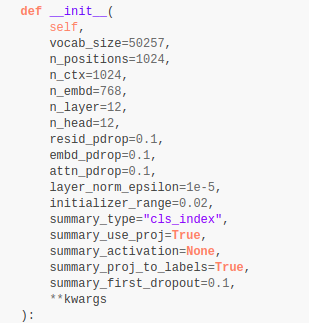

In [38]:
len(vocabulary)

912

In [318]:
# configuracion
params = {
    'vocab_size': len(vocabulary),  # 912
    'n_positions': 1024,  # default
    'n_ctx': 50,
    'n_embd': 8, # default: 768 in GPT-2 Small
                 # (Reducir este parámetro no mejora tanto el
                 # rendimiento segun https://medium.com/huggingface/distilbert-8cf3380435b5)
    'n_layer': 3, # default: 12 in GPT-2 Small
    'n_head': 4,  # default: 12 (n_embd % n_head must be 0)
}
config = GPT2Config(**params)

In [380]:
model = GPT2LMHeadModel(config)

In [320]:
model.num_parameters()

18120

In [263]:
CONTEXT_SIZE = 50


def build_ngrams(train_paths, context_size=CONTEXT_SIZE, stride=10):
    all_ngrams = []

    for path in train_paths:
        
        song = read_file(path)  # sequence of tokens
        
        song = [vocabulary_dict[token] for token in song]

        ngrams = [([song[j] for j in range(i, i + context_size)], song[i + context_size])
                  for i in range(0, len(song) - context_size, stride)]

        all_ngrams.extend(ngrams)
    
    return all_ngrams

In [104]:
ngrams = build_ngrams(paths[:int(len(paths) / 10)])

In [67]:
from torch.utils.data.dataset import Dataset

In [406]:
class MyDataset(Dataset):
    
    def __init__(self, ngrams):
        self.ngrams = ngrams
    
    def __len__(self):
        return len(self.ngrams)
    
    def __getitem__(self, index):
        X, y = self.ngrams[index]
        data = {}
        data["input_ids"] = torch.LongTensor(X)
        data["labels"] = torch.LongTensor(X)
        return data

In [407]:
dataset = MyDataset(ngrams)

In [408]:
dataset[3]

{'input_ids': tensor([263, 360, 727, 481, 263, 342, 263, 653, 843, 320,  22, 590, 396, 821,
         263,  48, 263, 210, 170, 259, 263,  67, 263, 380, 162, 263,  18, 120,
         808, 263, 653, 616, 263, 360, 788, 481, 398, 263, 727, 342, 827, 193,
         373, 210, 259, 329, 516, 653, 616, 228]),
 'labels': tensor([263, 360, 727, 481, 263, 342, 263, 653, 843, 320,  22, 590, 396, 821,
         263,  48, 263, 210, 170, 259, 263,  67, 263, 380, 162, 263,  18, 120,
         808, 263, 653, 616, 263, 360, 788, 481, 398, 263, 727, 342, 827, 193,
         373, 210, 259, 329, 516, 653, 616, 228])}

In [512]:
from transformers import Trainer, TrainingArguments
# from torch.utils.tensorboard import SummaryWriter

# writer = SummaryWriter('logs/gpt2_2')

training_args = TrainingArguments(
    output_dir="./ouputs/gpt2_1",
    logging_dir="./logs/gpt2_2",
    overwrite_output_dir=True,
    num_train_epochs=20,
#     per_gpu_train_batch_size=64,
#     save_steps=10_000,
#     save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
#     data_collator=data_collator,
    train_dataset=dataset,
    prediction_loss_only=True,
)

In [ ]:
trainer.train()

In [415]:
output = model(**dataset[2])

In [420]:
output[1].shape

torch.Size([50, 912])

# Generation

In [459]:
seq = torch.LongTensor([[vocabulary_dict[token] for token in read_file(paths[0])][:3]])
seq

tensor([[252, 210,  22]])

In [484]:
generated = model.generate(seq, max_length=50, repetition_penalty=1)
generated

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


tensor([[252, 210,  22, 263, 720, 263, 490, 263, 199, 120, 263, 720, 263, 665,
         263, 720, 263, 199, 263, 665, 255, 263, 665, 488, 263, 490, 263, 665,
         255, 263, 490, 263, 490, 263, 665, 120, 263, 490, 263, 665, 522, 263,
         490, 263, 665, 263, 665, 522, 263, 490]])

In [485]:
decoder = {index: token for token, index in vocabulary_dict.items()}

In [486]:
[decoder[index.item()] for index in list(generated[0])]

['TIMESHIFT<28>',
 'NOTE-ON<46>',
 'SET-VELOCITY<44>',
 'TIMESHIFT<1>',
 'NOTE-OFF<50>',
 'TIMESHIFT<1>',
 'NOTE-OFF<55>',
 'TIMESHIFT<1>',
 'NOTE-ON<50>',
 'SET-VELOCITY<46>',
 'TIMESHIFT<1>',
 'NOTE-OFF<50>',
 'TIMESHIFT<1>',
 'NOTE-ON<55>',
 'TIMESHIFT<1>',
 'NOTE-OFF<50>',
 'TIMESHIFT<1>',
 'NOTE-ON<50>',
 'TIMESHIFT<1>',
 'NOTE-ON<55>',
 'SET-VELOCITY<47>',
 'TIMESHIFT<1>',
 'NOTE-ON<55>',
 'SET-VELOCITY<59>',
 'TIMESHIFT<1>',
 'NOTE-OFF<55>',
 'TIMESHIFT<1>',
 'NOTE-ON<55>',
 'SET-VELOCITY<47>',
 'TIMESHIFT<1>',
 'NOTE-OFF<55>',
 'TIMESHIFT<1>',
 'NOTE-OFF<55>',
 'TIMESHIFT<1>',
 'NOTE-ON<55>',
 'SET-VELOCITY<46>',
 'TIMESHIFT<1>',
 'NOTE-OFF<55>',
 'TIMESHIFT<1>',
 'NOTE-ON<55>',
 'SET-VELOCITY<52>',
 'TIMESHIFT<1>',
 'NOTE-OFF<55>',
 'TIMESHIFT<1>',
 'NOTE-ON<55>',
 'TIMESHIFT<1>',
 'NOTE-ON<55>',
 'SET-VELOCITY<52>',
 'TIMESHIFT<1>',
 'NOTE-OFF<55>']

In [501]:
big_generated = [vocabulary_dict[token] for token in read_file(paths[0])][:50]
for i in range(100):
    generated = model.generate(torch.LongTensor([big_generated[:20]]), max_length=50,repetition_penalty=1)
    generated = [index.item() for index in list(generated[0])]
#     break
    big_generated.extend(generated[20:])
    print(i)

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0
1
2


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


3
4
5


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


6
7
8


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


9
10
11


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


12
13
14


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


15
16
17


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


18
19
20


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


21
22
23


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


24
25
26


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


27
28
29


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


30
31
32


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


33
34
35


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


36
37
38


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


39
40
41


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


42
43
44


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


45
46
47


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


48
49
50


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


51
52
53


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


54
55
56


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


57
58
59


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


60
61
62


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


63
64
65


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


66
67
68


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


69
70
71


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


72
73
74


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


75
76
77


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


78
79
80


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


81
82
83


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


84
85
86


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


87
88
89


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


90
91
92


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


93
94
95


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


96
97
98
99


In [502]:
big_generated

[252,
 210,
 22,
 259,
 445,
 616,
 590,
 653,
 590,
 320,
 351,
 263,
 396,
 821,
 590,
 48,
 67,
 263,
 259,
 763,
 263,
 380,
 828,
 263,
 210,
 313,
 18,
 808,
 616,
 398,
 263,
 360,
 727,
 481,
 263,
 342,
 263,
 653,
 843,
 320,
 22,
 590,
 396,
 821,
 263,
 48,
 263,
 210,
 170,
 259,
 263,
 665,
 263,
 490,
 263,
 490,
 263,
 665,
 263,
 490,
 263,
 490,
 263,
 490,
 263,
 665,
 836,
 263,
 665,
 263,
 665,
 255,
 263,
 665,
 255,
 263,
 490,
 263,
 665,
 263,
 263,
 199,
 263,
 720,
 263,
 720,
 263,
 720,
 263,
 720,
 263,
 490,
 263,
 665,
 255,
 263,
 720,
 263,
 490,
 263,
 199,
 120,
 263,
 199,
 836,
 263,
 199,
 763,
 263,
 199,
 263,
 490,
 263,
 199,
 263,
 490,
 263,
 665,
 263,
 665,
 836,
 263,
 490,
 263,
 490,
 263,
 490,
 263,
 665,
 263,
 490,
 263,
 665,
 120,
 263,
 490,
 263,
 665,
 120,
 263,
 263,
 490,
 263,
 490,
 263,
 665,
 120,
 263,
 665,
 263,
 490,
 263,
 665,
 263,
 490,
 263,
 665,
 255,
 263,
 490,
 263,
 490,
 263,
 490,
 263,
 665,
 263,
 490

In [503]:
tokens = [decoder[index] for index in big_generated]

In [472]:
import pypianoroll
from matplotlib import pyplot as plt
import numpy as np

In [473]:
class Parser:
    
    @staticmethod
    def load_midi_as_track(midi_file_path):
        """
        Lee un midi single-track y debuelve el objeto Track de pypianoroll
        """
        multitrack = pypianoroll.parse(midi_file_path)
        track = multitrack.tracks[0]
        return track

    @staticmethod
    def encode(pianoroll):
        """
        Recibe la matriz del track (pianoroll) y devuelve
        una lista con los tokens.
        """
        sequence = []
        pianoroll = pianoroll.astype('int8')

        previous_row = np.zeros(pianoroll.shape[1])
        previous_velocity = 0
        timeshift = 0

        for t, row in enumerate(pianoroll):

            if all(row == previous_row):
                timeshift += 1
            else:
                sequence.append(f'TIMESHIFT<{timeshift}>')
                timeshift = 1

                difference = row - previous_row
                changed_notes = np.where(difference != 0)[0]

                for n in changed_notes:

                    # Si la nota cambió y antes era 0, solo pudo haberse encendido.
                    if previous_row[n] == 0:
                        sequence.append(f'NOTE-ON<{n}>')

                    # Si la nota cambió y ahora esta en 0, solo pudo haberse apagado.
                    elif row[n] == 0:
                        sequence.append(f'NOTE-OFF<{n}>')

                    velocity = int(np.take(row, changed_notes).mean())
                    if velocity != previous_velocity and velocity != 0:
                        sequence.append(f'SET-VELOCITY<{velocity}>')
                        previous_velocity = velocity

            previous_row = row

        return sequence

    @staticmethod
    def decode(encoded_sequence):
        """
        Retorna una matriz que representa al pianoroll, dada
        una lista de tokens.
        """
        def get_number(token):
            return int(token.split('<')[1].strip('>'))

        pitches = 128

        new_pianoroll = []
        on_notes = list(np.zeros(pitches))
        velocity = 0

        for token in encoded_sequence:

            if 'TIMESHIFT' in token:
                new_row = np.array(on_notes) * velocity
                timesteps = get_number(token)

                for t in range(timesteps):
                    new_pianoroll.append(list(new_row))

            elif 'NOTE-ON' in token:
                note = get_number(token)
                on_notes[note] = 1

            elif 'NOTE-OFF' in token:
                note = get_number(token)
                on_notes[note] = 0

            elif 'SET-VELOCITY' in token:
                velocity = get_number(token)

        return np.array(new_pianoroll)

In [504]:
decoded = Parser.decode(tokens)
decoded

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

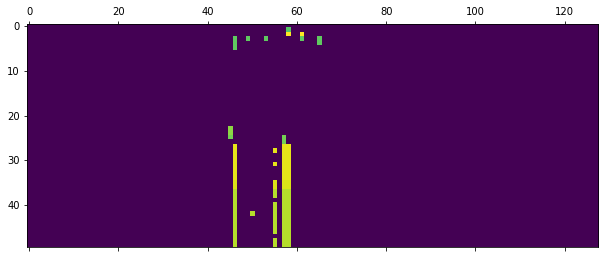

In [505]:
# Graficamos de vuelta el pianoroll
plt.matshow(decoded[50:100])

In [506]:
new_track = pypianoroll.Track(decoded)

In [507]:
new_multitrack = pypianoroll.Multitrack(tracks=[new_track])

In [508]:
new_multitrack.write('experiment.mid')

In [509]:
!vlc experiment.mid

VLC media player 3.0.11 Vetinari (revision 3.0.11-0-gdc0c5ced72)
[00005611a6052b10] main libvlc: Running vlc with the default interface. Use 'cvlc' to use vlc without interface.
Qt: Session management error: None of the authentication protocols specified are supported
[00007f6238001150] smf demux: Track name: unknown
fluidsynth: warning: Failed to pin the sample data to RAM; swapping is possible.
[00007f6238001150] smf demux: Track name: unknown
fluidsynth: warning: No preset found on channel 0 [bank=0 prog=0]
fluidsynth: warning: No preset found on channel 1 [bank=0 prog=0]
fluidsynth: warning: No preset found on channel 2 [bank=0 prog=0]
fluidsynth: warning: No preset found on channel 3 [bank=0 prog=0]
fluidsynth: warning: No preset found on channel 4 [bank=0 prog=0]
fluidsynth: warning: No preset found on channel 5 [bank=0 prog=0]
fluidsynth: warning: No preset found on channel 6 [bank=0 prog=0]
fluidsynth: warning: No preset found on channel 7 [bank=0 prog=0]
fluidsynth: warning: N